#Importing all the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr

#Importing all data and timeframe

In [2]:
ticker="AAPL"
start_date="2010-01-01"
end_date="2019-12-31"

In [3]:
data=yf.download(ticker,start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed


#Data Cleaning and Plotting

In [4]:
df=pd.DataFrame(data)
df=df.reset_index()
df=df.drop(['Date','Adj Close'],axis=1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


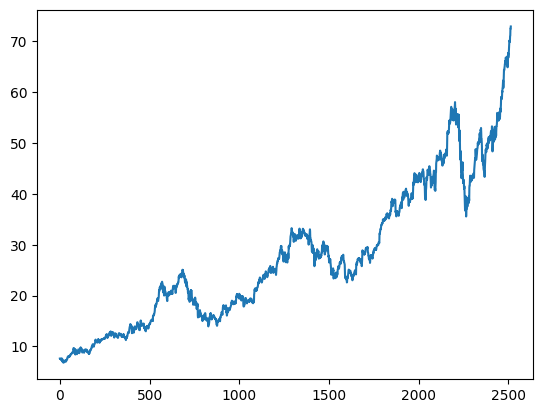

In [5]:
plt.plot(df.Close)

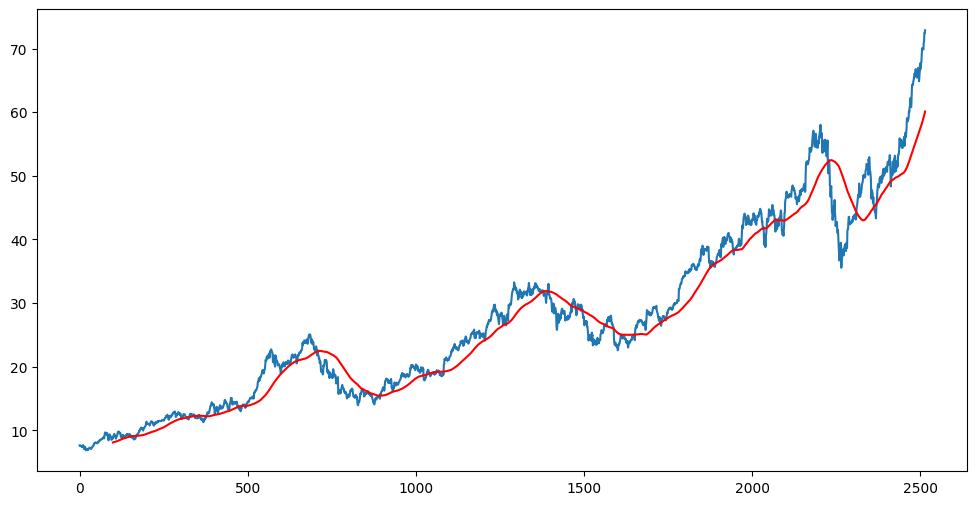

In [6]:
ma100=df.Close.rolling(100).mean()
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')

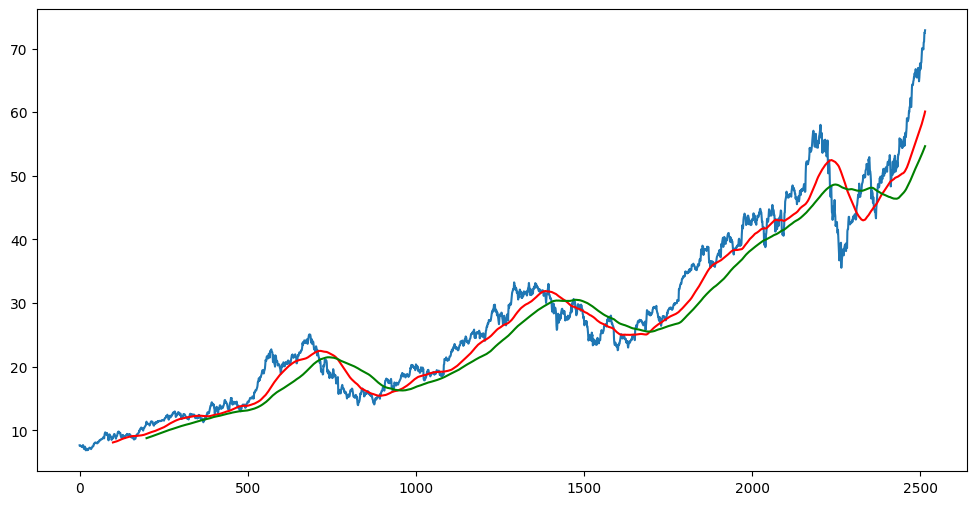

In [7]:
ma200=df.Close.rolling(200).mean()
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

#Data Training and testing

In [8]:
data_train=pd.DataFrame(df['Close'][0:int(len(df)*0.7)])
data_test=pd.DataFrame(df['Close'][int(len(df)*0.7):int(len(df))])

# print(data_train.shape)
print(data_test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_training_array=scaler.fit_transform(data_train)


(755, 1)


In [9]:
x_train=[]
y_train=[]
for i in range(100, data_training_array.shape[0]):
  x_train.append(data_training_array[i-100:i])
  y_train.append(data_training_array[i,0])

x_train, y_train=np.array(x_train), np.array(y_train)

x_train.shape

(1660, 100, 1)

#Machine Learning Model

In [10]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential

In [11]:
model = Sequential()
model.add(LSTM(units =50, activation = "relu", return_sequences= True,
               input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units =60, activation = "relu", return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units =80, activation = "relu", return_sequences= True))
model.add(Dropout(0.4))

model.add(LSTM(units =120, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [13]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=50)

Epoch 1/50
52/52 [==============================] - 24s 316ms/step - loss: 0.0546
Epoch 2/50
52/52 [==============================] - 16s 299ms/step - loss: 0.0154
Epoch 3/50
52/52 [==============================] - 15s 291ms/step - loss: 0.0108
Epoch 4/50
52/52 [==============================] - 15s 282ms/step - loss: 0.0091
Epoch 5/50
52/52 [==============================] - 14s 277ms/step - loss: 0.0089
Epoch 6/50
52/52 [==============================] - 14s 271ms/step - loss: 0.0082
Epoch 7/50
52/52 [==============================] - 14s 275ms/step - loss: 0.0083
Epoch 8/50
52/52 [==============================] - 14s 261ms/step - loss: 0.0072
Epoch 9/50
52/52 [==============================] - 13s 248ms/step - loss: 0.0075
Epoch 10/50
52/52 [==============================] - 16s 309ms/step - loss: 0.0075
Epoch 11/50
52/52 [==============================] - 17s 327ms/step - loss: 0.0074
Epoch 12/50
52/52 [==============================] - 17s 322ms/step - loss: 0.0075
Epoch 13/50
5

In [14]:
model.save('keras_model.h5')
past_100_days=data_train.tail(100)
final_df=pd.concat([past_100_days,data_test],ignore_index=True)

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
final_df.head()

,Close
0,27.092501
1,27.202499
2,27.000000
3,26.982500
4,27.045000


In [16]:
input_data = scaler.fit_transform(final_df)

In [17]:
x_test=[]
y_test=[]
for i in range(100, input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])

x_test, y_test=np.array(x_test), np.array(y_test)

x_test.shape
y_test.shape

(755,)

#Making Predictions

In [18]:
y_predicted=model.predict(x_test)



24/24 [==============================] - 2s 48ms/step


In [19]:
scaler.scale_

array([0.02123255])

In [20]:
scale_factor=1/0.02123255
y_predicted=y_predicted*scale_factor
y_test=y_test*scale_factor

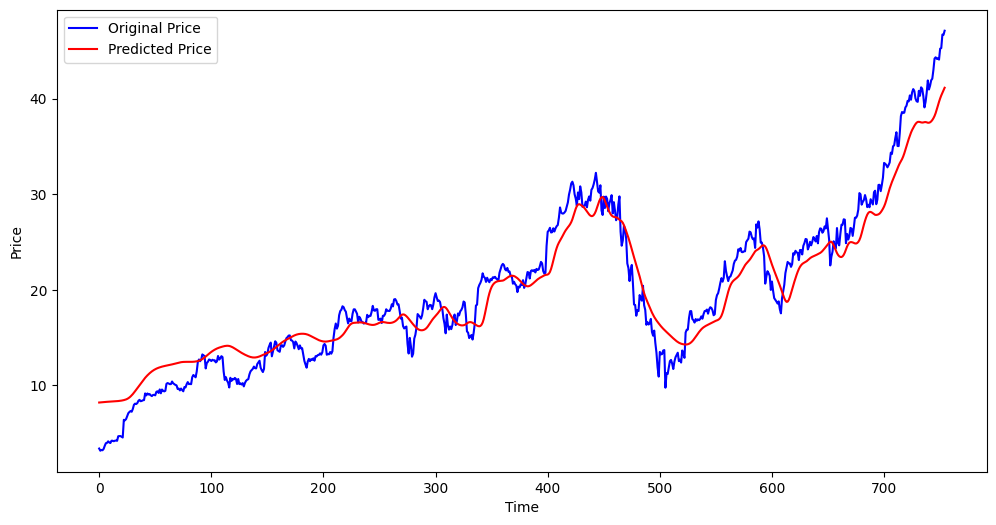

In [21]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b', label = 'Original Price')
plt.plot(y_predicted,'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()